In [57]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [58]:
import tensorflow as tf
print(tf.__version__)


2.10.0


In [59]:
!pip install plotly

In [60]:
# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Building Model
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy


# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

# Model Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

from sklearn.model_selection import train_test_split

In [61]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [62]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [63]:
train_data = train_df('D:\Mahir\Datasets\Merged Dataset 1\Training')

In [64]:
train_data


,Class Path,Class
0,D:\Mahir\Datasets\Merged Dataset 1\Training\gl...,glioma
1,D:\Mahir\Datasets\Merged Dataset 1\Training\gl...,glioma
2,D:\Mahir\Datasets\Merged Dataset 1\Training\gl...,glioma
3,D:\Mahir\Datasets\Merged Dataset 1\Training\gl...,glioma
4,D:\Mahir\Datasets\Merged Dataset 1\Training\gl...,glioma
...,...,...
5707,D:\Mahir\Datasets\Merged Dataset 1\Training\pi...,pituitary
5708,D:\Mahir\Datasets\Merged Dataset 1\Training\pi...,pituitary
5709,D:\Mahir\Datasets\Merged Dataset 1\Training\pi...,pituitary
5710,D:\Mahir\Datasets\Merged Dataset 1\Training\pi...,pituitary


In [65]:
test_data = test_df('D:\Mahir\Datasets\Merged Dataset 1\Testing')

In [66]:
test_data

,Class Path,Class
0,D:\Mahir\Datasets\Merged Dataset 1\Testing\gli...,glioma
1,D:\Mahir\Datasets\Merged Dataset 1\Testing\gli...,glioma
2,D:\Mahir\Datasets\Merged Dataset 1\Testing\gli...,glioma
3,D:\Mahir\Datasets\Merged Dataset 1\Testing\gli...,glioma
4,D:\Mahir\Datasets\Merged Dataset 1\Testing\gli...,glioma
...,...,...
1306,D:\Mahir\Datasets\Merged Dataset 1\Testing\pit...,pituitary
1307,D:\Mahir\Datasets\Merged Dataset 1\Testing\pit...,pituitary
1308,D:\Mahir\Datasets\Merged Dataset 1\Testing\pit...,pituitary
1309,D:\Mahir\Datasets\Merged Dataset 1\Testing\pit...,pituitary


In [67]:
train_path = 'D:\Mahir\Datasets\Merged Dataset 1\Training'
test_path = 'D:\Mahir\Datasets\Merged Dataset 1\Testing'

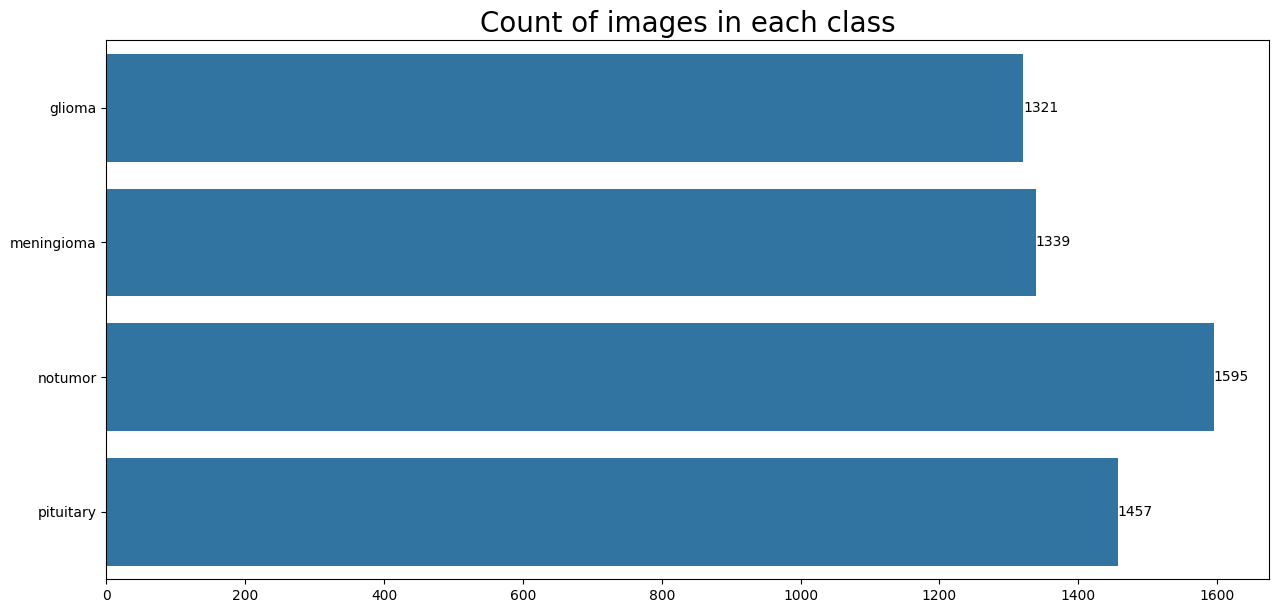

In [68]:
# Count of images in each class in train data
plt.figure(figsize=(15,7))
ax = sns.countplot(data=train_data , y=train_data ['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

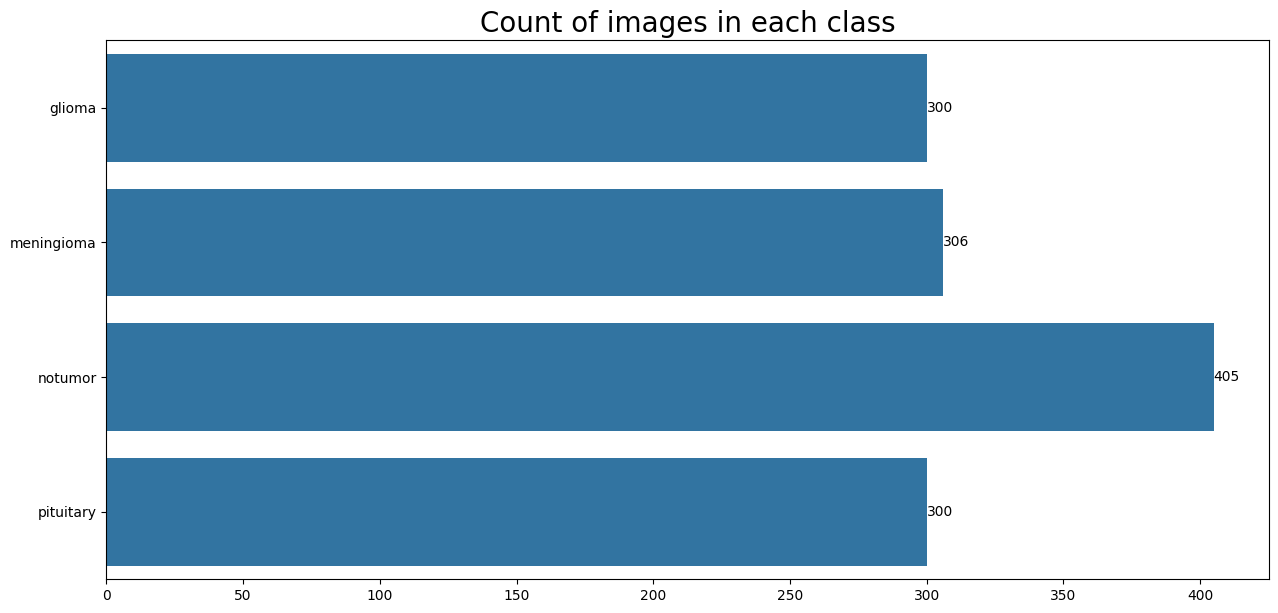

In [69]:
# Count of images in each class in train data
plt.figure(figsize=(15,7))
ax = sns.countplot(data=test_data , y=test_data ['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()


In [70]:
# Image size
image_size = (160, 160)

# Training batch size
batch_size = 32

In [71]:
# Data preprocessing without any augmentation, only rescaling and validation split
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

# Creating training data generator
train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=(160, 160),
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    subset='training',
                                                    seed=0)

# Creating validation data generator
val_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=(160, 160),
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  subset='validation',
                                                 shuffle=False,
                                                  seed=0)

# Applying the generator to testing data, only rescaling
test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=(160, 160),
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  subset='training', 
                                                  shuffle=False)

Found 5712 images belonging to 4 classes.
Found 655 images belonging to 4 classes.
Found 656 images belonging to 4 classes.


In [72]:
def show_ImageDataGenerator(ImageDataGenerator, num_samples=5, figsize=(12, 12), save=False):
    """
    Function to viusalize how the ImageDataGenerator augments the data
    """

    # Generate augmented samples
    # Use __next__() instead of next()
    augmented_samples = train_generator.__next__()

    # Extract images from the batch
    images = augmented_samples[0][:num_samples]

    # Display the augmented images
    fig, axes = plt.subplots(1, num_samples, figsize=figsize)

    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.axis('off')

    plt.tight_layout()

    if save:
        plt.savefig('show_ImageDataGenerator.pdf')

    plt.show()

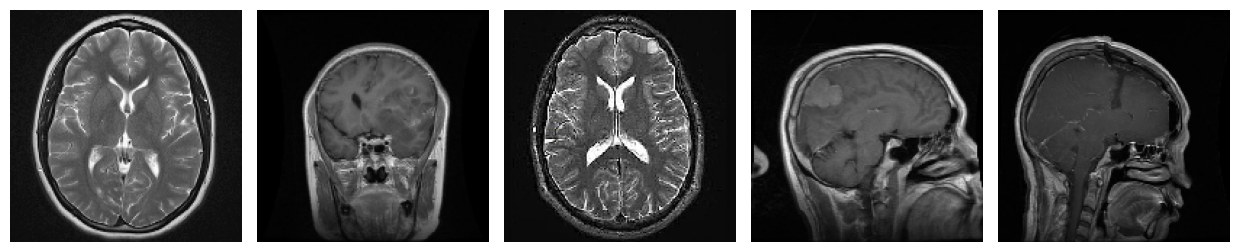

In [73]:
show_ImageDataGenerator(train_datagen, num_samples=5, figsize=(12.5, 8), save=False)


In [74]:
# Image shape: height, width, RBG
image_shape = (image_size[0], image_size[1], 3)


print(f'Image shape: {image_shape}')
print(f'Batch size: {batch_size}')
print(f'Number of Train batches: {len(train_generator)}')
print(f'Number of Validation batches: {len(val_generator)}')
print(f'Number of Testing batches: {len(test_generator)}')

Image shape: (160, 160, 3)
Batch size: 32
Number of Train batches: 179
Number of Validation batches: 21
Number of Testing batches: 21


In [75]:
Classes_Map = train_generator.class_indices

num_classes = len(Classes_Map)

print("Number of Classes:", num_classes)
Classes_Map

Number of Classes: 4


{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [76]:
def plot_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  plt.figure(figsize=(15,5))
  plt.style.use('ggplot')


  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, 'bo-' , label = "TrainL oss")
  plt.plot(epochs, val_loss, 'o-' , color='orange', label = "Val Loss")
  plt.title("Loss")
  plt.xlabel("epochs")
  plt.legend()


  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, 'bo-' , label = "Train Acc")
  plt.plot(epochs, val_accuracy, 'o-' , color='orange' , label = "Val Acc")
  plt.title("Accuracy")
  plt.xlabel("epochs")
  plt.legend()

  plt.style.use('default')

# VGG16 MODEL

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(160, 160, 3))


for layer in base_model_vgg.layers[:-10]:
    layer.trainable = False

for layer in base_model_vgg.layers[-10:]:
    layer.trainable = True

# Add custom classification head
x = base_model_vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model_vgg = Model(inputs=base_model_vgg.input, outputs=output)


model_vgg.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

model_vgg.summary()

In [28]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

num_epochs = 50

early_stopper = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)

checkpoint_path = r'D:\Mahir\Brain\Checkpoints\vgg16_no_aug_d1_epoch50_p_7.keras'
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

vgg_history = model_vgg.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=val_generator,
    callbacks=[early_stopper, model_checkpoint]
)

model_vgg.load_weights(checkpoint_path)

model_vgg.summary()

Epoch 1/50
179/179 [==============================] - ETA: 0s - loss: 0.1001 - accuracy: 0.9674 - precision: 0.9707 - recall: 0.9643
Epoch 1: val_loss improved from inf to 0.21591, saving model to D:\Mahir\Brain\Checkpoints\vgg16_no_aug_d1_epoch50_p_7.keras
179/179 [==============================] - 20s 111ms/step - loss: 0.1001 - accuracy: 0.9674 - precision: 0.9707 - recall: 0.9643 - val_loss: 0.2159 - val_accuracy: 0.9282 - val_precision: 0.9332 - val_recall: 0.9176
Epoch 2/50
179/179 [==============================] - ETA: 0s - loss: 0.0583 - accuracy: 0.9807 - precision: 0.9835 - recall: 0.9785
Epoch 2: val_loss improved from 0.21591 to 0.09469, saving model to D:\Mahir\Brain\Checkpoints\vgg16_no_aug_d1_epoch50_p_7.keras
179/179 [==============================] - 20s 110ms/step - loss: 0.0583 - accuracy: 0.9807 - precision: 0.9835 - recall: 0.9785 - val_loss: 0.0947 - val_accuracy: 0.9740 - val_precision: 0.9740 - val_recall: 0.9725
Epoch 3/50
179/179 [============================

In [29]:
!pip install pickle5

  Using cached pickle5-0.0.11.tar.gz (132 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for pickle5
Failed to build pickle5


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [15 lines of output]
  running bdist_wheel
  running build
  running build_py
  creating build\lib.win-amd64-cpython-310\pickle5
  copying pickle5\pickle.py -> build\lib.win-amd64-cpython-310\pickle5
  copying pickle5\pickletools.py -> build\lib.win-amd64-cpython-310\pickle5
  copying pickle5\__init__.py -> build\lib.win-amd64-cpython-310\pickle5
  creating build\lib.win-amd64-cpython-310\pickle5\test
  copying pickle5\test\pickletester.py -> build\lib.win-amd64-cpython-310\pickle5\test
  copying pickle5\test\test_pickle.py -> build\lib.win-amd64-cpython-310\pickle5\test
  copying pickle5\test\test_picklebuffer.py -> build\lib.win-amd64-cpython-310\pickle5\test
  copying pickle5\test\__init__.py -> build\lib.win-amd64-cpython-310\pickle5\test
  running build_ext
  building 'pickle5._pickle' extension
  error: Microsoft Visual C++ 14.0 or greater is required. Get it with 

In [30]:
import pickle

# Save the vgg_history object using pickle
with open('./history/vgg16_no_aug_d1.pkl', 'wb') as f:
    pickle.dump(vgg_history.history, f)

print("vgg_history saved successfully.")


vgg_history saved successfully.


In [32]:
# Load the vgg_history object
with open('./history/vgg16_no_aug_d1.pkl', 'rb') as f:
    loaded_history = pickle.load(f)

print("vgg_history loaded successfully.")


vgg_history loaded successfully.


In [33]:
loaded_history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

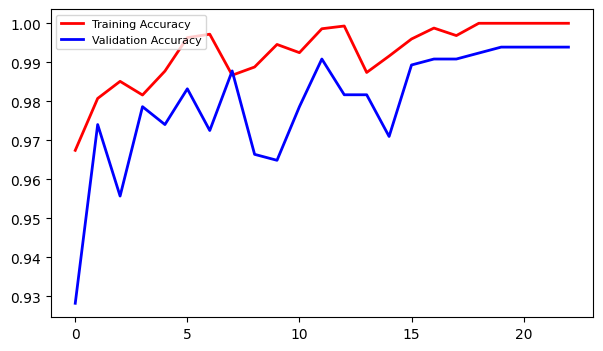

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

acc = loaded_history['accuracy']
val_acc = loaded_history['val_accuracy']
epochs = range(len(acc))

fig = plt.figure(figsize=(7,4))

# Set the linewidth to a smaller value (e.g., 2)
plt.plot(epochs, acc, 'r', label="Training Accuracy", linewidth=2)
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy", linewidth=2)

# Adjust the legend font size
plt.legend(loc='upper left', fontsize=8)  # Set fontsize to your preference

plt.show()


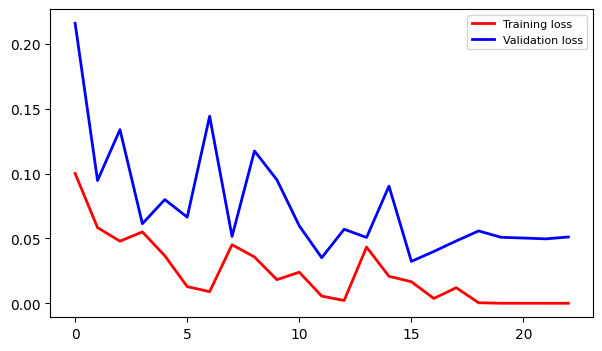

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

loss = loaded_history['loss']
val_loss = loaded_history['val_loss']
epochs = range(len(loss))

fig = plt.figure(figsize=(7,4))

# Set the linewidth to a smaller value (e.g., 2)
plt.plot(epochs, loss, 'r', label="Training loss", linewidth=2)
plt.plot(epochs, val_loss, 'b', label="Validation loss", linewidth=2)

# Adjust the legend font size
plt.legend(loc='upper right', fontsize=8)  # Set fontsize to your preference

plt.show()


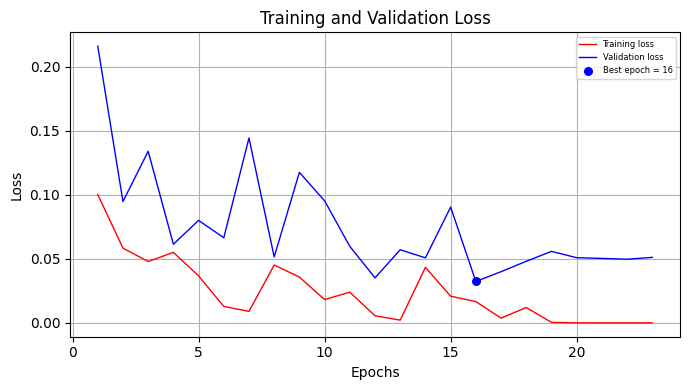

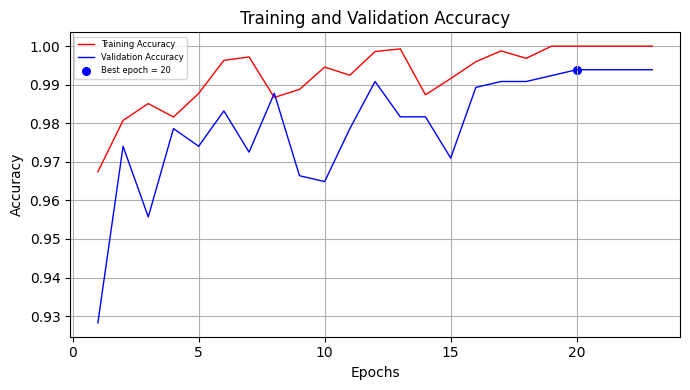

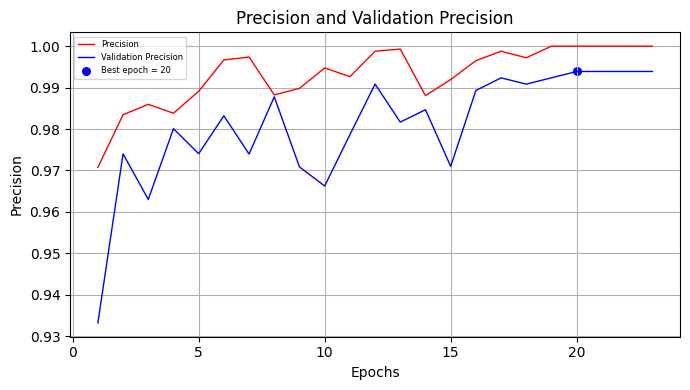

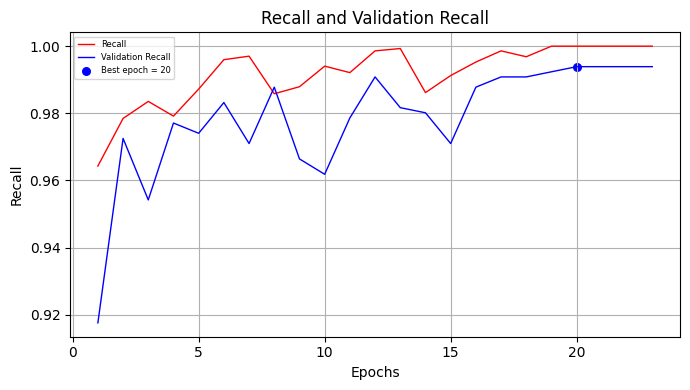

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `vgg_history` is the history object from the model training
tr_acc = loaded_history['accuracy']
tr_loss = loaded_history['loss']
tr_per = loaded_history['precision']
tr_recall = loaded_history['recall']
val_acc = loaded_history['val_accuracy']
val_loss = loaded_history['val_loss']
val_per = loaded_history['val_precision']
val_recall = loaded_history['val_recall']

# Indices of the best epochs
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

# Epochs for plotting
Epochs = [i + 1 for i in range(len(tr_acc))]

# Labels for best epochs
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'

# Function to plot the metrics with customizable legend position
def plot_metric(x, y1, y2, label1, label2, best_epoch_idx, best_value, title, xlabel, ylabel, best_epoch_label, legend_loc='upper left'):
    plt.figure(figsize=(7, 4))
    plt.plot(x, y1, 'r-', label=label1, linewidth=1)  # Red line for training metric
    plt.plot(x, y2, 'b-', label=label2, linewidth=1)  # Blue line for validation metric
    plt.scatter(best_epoch_idx + 1, best_value, s=30, c='blue', label=best_epoch_label)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc=legend_loc, fontsize=6)  # Adjusting legend font size and position
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot for Training and Validation Loss with custom legend position
plot_metric(Epochs, tr_loss, val_loss, 'Training loss', 'Validation loss', index_loss, val_lowest, 
            'Training and Validation Loss', 'Epochs', 'Loss', loss_label, legend_loc='upper right')

# Plot for Training and Validation Accuracy with custom legend position
plot_metric(Epochs, tr_acc, val_acc, 'Training Accuracy', 'Validation Accuracy', index_acc, acc_highest, 
            'Training and Validation Accuracy', 'Epochs', 'Accuracy', acc_label, legend_loc='upper left')

# Plot for Precision and Validation Precision with custom legend position
plot_metric(Epochs, tr_per, val_per, 'Precision', 'Validation Precision', index_precision, per_highest, 
            'Precision and Validation Precision', 'Epochs', 'Precision', per_label, legend_loc='upper left')

# Plot for Recall and Validation Recall with custom legend position
plot_metric(Epochs, tr_recall, val_recall, 'Recall', 'Validation Recall', index_recall, recall_highest, 
            'Recall and Validation Recall', 'Epochs', 'Recall', recall_label, legend_loc='upper left')


In [37]:
train_score = model_vgg.evaluate(train_generator, verbose=1)
valid_score = model_vgg.evaluate(val_generator, verbose=1)
test_score = model_vgg.evaluate(test_generator, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")


21/21 [==============================] - 1s 56ms/step - loss: 0.0787 - accuracy: 0.9802 - precision: 0.9817 - recall: 0.9802
Train Loss: 0.0042
Train Accuracy: 99.88%
--------------------
Validation Loss: 0.0323
Validation Accuracy: 98.93%
--------------------
Test Loss: 0.0787
Test Accuracy: 98.02%


In [38]:
preds = model_vgg.predict(test_generator)
y_pred = np.argmax(preds, axis=1)

21/21 [==============================] - 1s 62ms/step


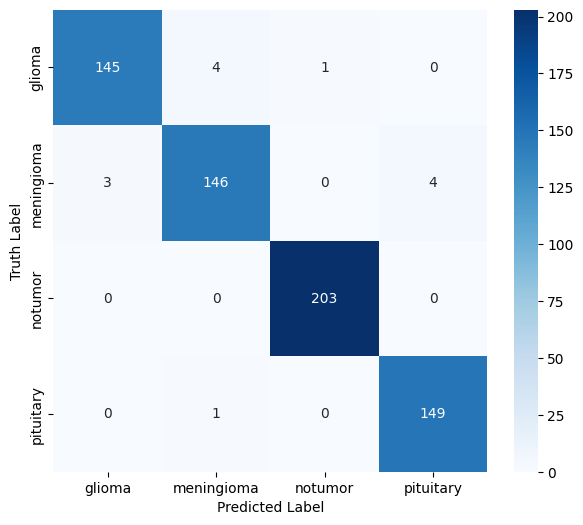

In [39]:

cm = confusion_matrix(test_generator.classes, y_pred)
class_dict = train_generator.class_indices
labels = list(class_dict.keys())
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [40]:
clr = classification_report(test_generator.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       150
           1       0.97      0.95      0.96       153
           2       1.00      1.00      1.00       203
           3       0.97      0.99      0.98       150

    accuracy                           0.98       656
   macro avg       0.98      0.98      0.98       656
weighted avg       0.98      0.98      0.98       656



# Xception

In [41]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dropout, Dense
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
import tensorflow as tf

img_shape=(160,160,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

# for layer in base_model.layers:
#     layer.trainable = False

model_xception = Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

# Call the model with a sample input to define the output shapes
sample_input = tf.keras.Input(shape=img_shape)  # Create a sample input tensor
_ = model_xception(sample_input)  # Call the model to infer shapes

model_xception.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

model_xception.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 21,124,268
Trainable params: 21,069,740
No

In [42]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

num_epochs = 50

early_stopper = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)

checkpoint_path = r'D:\Mahir\Brain\Checkpoints\xception_no_aug_d1_epoch50_p_7.keras'
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

xception_history = model_xception.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=val_generator,
    callbacks=[early_stopper, model_checkpoint]
)

model_xception.load_weights(checkpoint_path)

model_xception.summary()

Epoch 1/50
179/179 [==============================] - ETA: 0s - loss: 0.4546 - accuracy: 0.8269 - precision_1: 0.9002 - recall_1: 0.7581
Epoch 1: val_loss improved from inf to 0.41471, saving model to D:\Mahir\Brain\Checkpoints\xception_no_aug_d1_epoch50_p_7.keras
179/179 [==============================] - 36s 171ms/step - loss: 0.4546 - accuracy: 0.8269 - precision_1: 0.9002 - recall_1: 0.7581 - val_loss: 0.4147 - val_accuracy: 0.8641 - val_precision_1: 0.8730 - val_recall_1: 0.8504
Epoch 2/50
179/179 [==============================] - ETA: 0s - loss: 0.0948 - accuracy: 0.9697 - precision_1: 0.9735 - recall_1: 0.9645
Epoch 2: val_loss improved from 0.41471 to 0.15398, saving model to D:\Mahir\Brain\Checkpoints\xception_no_aug_d1_epoch50_p_7.keras
179/179 [==============================] - 29s 164ms/step - loss: 0.0948 - accuracy: 0.9697 - precision_1: 0.9735 - recall_1: 0.9645 - val_loss: 0.1540 - val_accuracy: 0.9496 - val_precision_1: 0.9525 - val_recall_1: 0.9481
Epoch 3/50
179/179

In [43]:
import pickle

# Save the vgg_history object using pickle
with open('./history/xception_no_aug_d1.pkl', 'wb') as f:
    pickle.dump(xception_history.history, f)

print("xception_history saved successfully.")


xception_history saved successfully.


In [79]:
# Load the vgg_history object
with open('./history/xception_no_aug_d1.pkl', 'rb') as f:
    loaded_history_x = pickle.load(f)

print("xception_history loaded successfully. into loaded_history_x")


xception_history loaded successfully. into loaded_history_x


In [80]:
loaded_history_x.keys()

dict_keys(['loss', 'accuracy', 'precision_1', 'recall_1', 'val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1'])

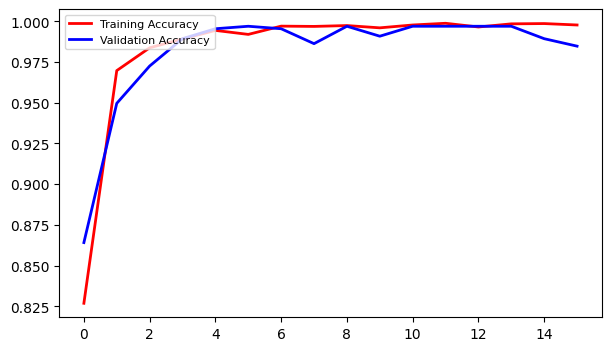

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

acc = loaded_history_x['accuracy']
val_acc = loaded_history_x['val_accuracy']
epochs = range(len(acc))

fig = plt.figure(figsize=(7,4))

# Set the linewidth to a smaller value (e.g., 2)
plt.plot(epochs, acc, 'r', label="Training Accuracy", linewidth=2)
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy", linewidth=2)

# Adjust the legend font size
plt.legend(loc='upper left', fontsize=8)  # Set fontsize to your preference

plt.show()


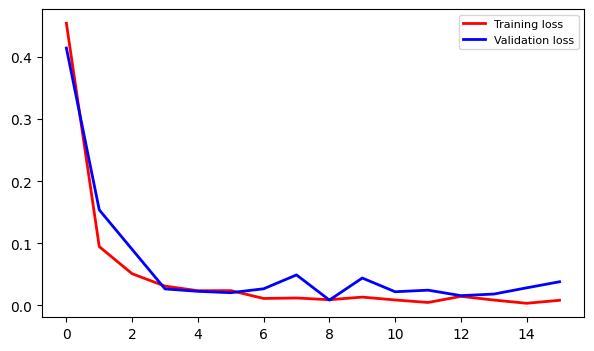

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

loss = loaded_history_x['loss']
val_loss = loaded_history_x['val_loss']
epochs = range(len(loss))

fig = plt.figure(figsize=(7,4))

# Set the linewidth to a smaller value (e.g., 2)
plt.plot(epochs, loss, 'r', label="Training loss", linewidth=2)
plt.plot(epochs, val_loss, 'b', label="Validation loss", linewidth=2)

# Adjust the legend font size
plt.legend(loc='upper right', fontsize=8)  # Set fontsize to your preference

plt.show()


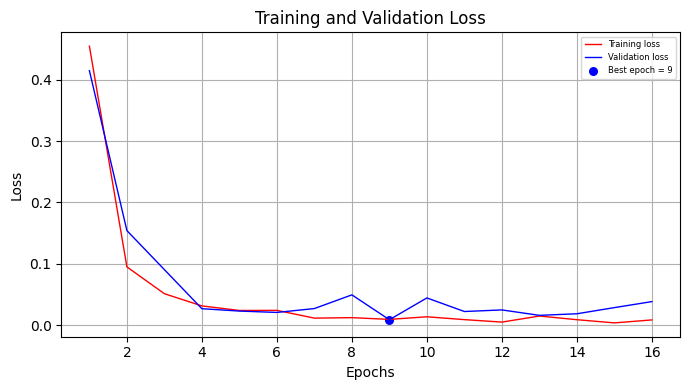

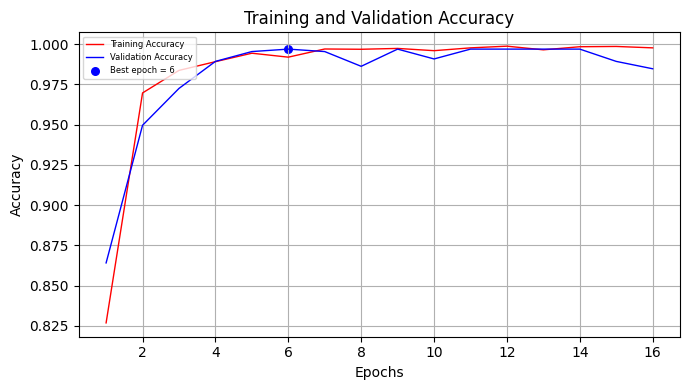

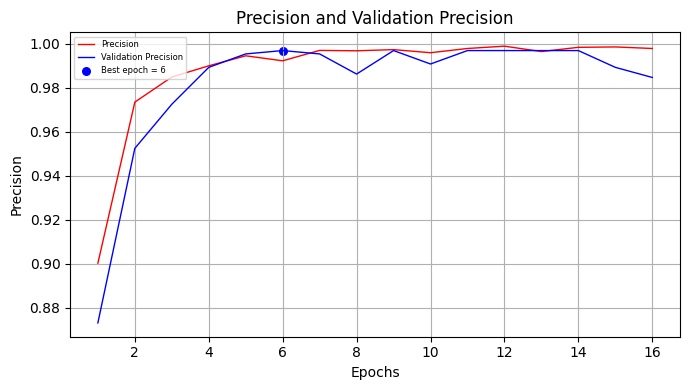

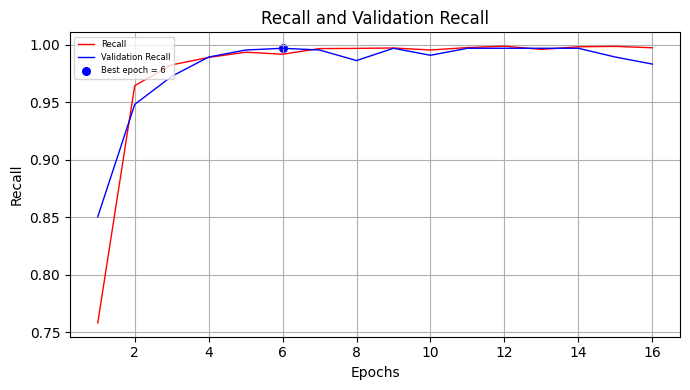

In [83]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `vgg_history` is the history object from the model training
tr_acc = loaded_history_x['accuracy']
tr_loss = loaded_history_x['loss']
tr_per = loaded_history_x['precision_1']
tr_recall = loaded_history_x['recall_1']
val_acc = loaded_history_x['val_accuracy']
val_loss = loaded_history_x['val_loss']
val_per = loaded_history_x['val_precision_1']
val_recall = loaded_history_x['val_recall_1']

# Indices of the best epochs
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

# Epochs for plotting
Epochs = [i + 1 for i in range(len(tr_acc))]

# Labels for best epochs
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'

# Function to plot the metrics with customizable legend position
def plot_metric(x, y1, y2, label1, label2, best_epoch_idx, best_value, title, xlabel, ylabel, best_epoch_label, legend_loc='upper left'):
    plt.figure(figsize=(7, 4))
    plt.plot(x, y1, 'r-', label=label1, linewidth=1)  # Red line for training metric
    plt.plot(x, y2, 'b-', label=label2, linewidth=1)  # Blue line for validation metric
    plt.scatter(best_epoch_idx + 1, best_value, s=30, c='blue', label=best_epoch_label)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc=legend_loc, fontsize=6)  # Adjusting legend font size and position
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot for Training and Validation Loss with custom legend position
plot_metric(Epochs, tr_loss, val_loss, 'Training loss', 'Validation loss', index_loss, val_lowest, 
            'Training and Validation Loss', 'Epochs', 'Loss', loss_label, legend_loc='upper right')

# Plot for Training and Validation Accuracy with custom legend position
plot_metric(Epochs, tr_acc, val_acc, 'Training Accuracy', 'Validation Accuracy', index_acc, acc_highest, 
            'Training and Validation Accuracy', 'Epochs', 'Accuracy', acc_label, legend_loc='upper left')

# Plot for Precision and Validation Precision with custom legend position
plot_metric(Epochs, tr_per, val_per, 'Precision', 'Validation Precision', index_precision, per_highest, 
            'Precision and Validation Precision', 'Epochs', 'Precision', per_label, legend_loc='upper left')

# Plot for Recall and Validation Recall with custom legend position
plot_metric(Epochs, tr_recall, val_recall, 'Recall', 'Validation Recall', index_recall, recall_highest, 
            'Recall and Validation Recall', 'Epochs', 'Recall', recall_label, legend_loc='upper left')


In [84]:
train_score = model_xception.evaluate(train_generator, verbose=1)
valid_score = model_xception.evaluate(val_generator, verbose=1)
test_score = model_xception.evaluate(test_generator, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")


21/21 [==============================] - 5s 222ms/step - loss: 0.0908 - accuracy: 0.9817 - precision_1: 0.9817 - recall_1: 0.9817
Train Loss: 0.0021
Train Accuracy: 99.93%
--------------------
Validation Loss: 0.0087
Validation Accuracy: 99.69%
--------------------
Test Loss: 0.0908
Test Accuracy: 98.17%


In [85]:
preds = model_xception.predict(test_generator)
y_pred = np.argmax(preds, axis=1)

21/21 [==============================] - 4s 193ms/step


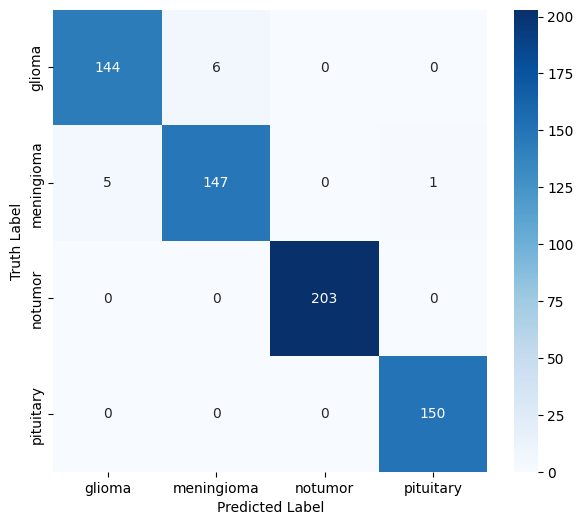

In [87]:

cm = confusion_matrix(test_generator.classes, y_pred)
class_dict = train_generator.class_indices
labels = list(class_dict.keys())
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [88]:
clr = classification_report(test_generator.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       150
           1       0.96      0.96      0.96       153
           2       1.00      1.00      1.00       203
           3       0.99      1.00      1.00       150

    accuracy                           0.98       656
   macro avg       0.98      0.98      0.98       656
weighted avg       0.98      0.98      0.98       656

